In [20]:
from pvtrace import *
# Some packages used by pvtrace are a little noisy
logging.getLogger('trimesh').disabled = True
logging.getLogger('shapely.geos').disabled = True
logging.getLogger('numpy').disabled = True
logging.getLogger('matplotlib').disabled = True
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


# Ray-tracing simulations of luminescent solar concentrators

*pvtrace* has been validated against other simulations codes of luminescent solar concentrators (LSCs),

![](Validation.png "pvtrace comparison with other simulation codes")

It includes a high-level API specifically for simulating these devices.

## LSC without solar cells

The following code simulates a LSC with the following properies:

- bare plate without solar cells
- refractive index 1.5 (default)
- contains Lumogen F Red 305 (default)
- assumes 0.02 cm-1 background absorption coefficient (default)
- spotlight illumination on top surface with 555nm monochromatic light (default)

In [2]:
lsc = LSC((5.0, 5.0, 1.0))  # size in cm
lsc.show()  # open visualiser
lsc._renderer.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [3]:
lsc.simulate(1000)  # emit 100 rays
lsc.report()        # print report

Tracing finished.
Preparing results.

Simulation Report
-----------------

Surface Counts:
        Solar In  Solar Out  Luminescent Out  Luminescent In
left           0          0               79               0
right          0          0               82               0
near           0          0               56               0
far            0          0               60               0
top         1000         40              204               0
bottom         0          2              129               0

Summary:
Optical Efficiency                                                               0
Waveguide Efficiency                                                             0
Waveguide Efficiency (Thermodynamic Prediction)                           0.642857
Non-radiative Loss (fraction):                                               0.348
Incident                                                                      1000
Geometric Concentration                                  

## LSC with solar cells on edges

Note, solar cells are not visualised in the renderer.

In [7]:
lsc = LSC((5.0, 5.0, 1.0))
# Add solar cells to edge faces
lsc.add_solar_cell({'left', 'right', 'near', 'far'})
# NB solar cells are not rendered
lsc.show()
lsc._renderer.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [8]:
lsc.simulate(100)
lsc.report()

Tracing finished.
Preparing results.

Simulation Report
-----------------

Surface Counts:
        Solar In  Solar Out  Luminescent Out  Luminescent In
left           0          0               13               0
right          0          0               11               0
near           0          0               11               0
far            0          0                9               0
top          100          2               21               0
bottom         0          0               10               0

Summary:
Optical Efficiency                                                            0.44
Waveguide Efficiency                                                      0.586667
Waveguide Efficiency (Thermodynamic Prediction)                           0.642857
Non-radiative Loss (fraction):                                                0.23
Incident                                                                       100
Geometric Concentration                                  

## LSC with solar cells on edges and back surface reflector

Note, solar cells and back surface reflector are not visualised in the renderer.

In [10]:
lsc = LSC((5.0, 5.0, 1.0))
# Add solar cells to edge faces
lsc.add_solar_cell({'left', 'right', 'near', 'far'})
# Add a perfect metal mirrors to the bottom surface
lsc.add_back_surface_mirror()
# NB solar cells are not rendered
lsc.show()
lsc._renderer.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7004/static/


In [11]:
lsc.simulate(100)
lsc.report()

Tracing finished.
Preparing results.

Simulation Report
-----------------

Surface Counts:
        Solar In  Solar Out  Luminescent Out  Luminescent In
left           0          0                9               0
right          0          0                7               0
near           0          0               10               0
far            0          0                8               0
top          100          2               37               0
bottom         0          0                0               0

Summary:
Optical Efficiency                                                            0.34
Waveguide Efficiency                                                      0.478873
Waveguide Efficiency (Thermodynamic Prediction)                           0.642857
Non-radiative Loss (fraction):                                                0.27
Incident                                                                       100
Geometric Concentration                                  

## LSC with custom ilumination spectrum and dye

In [22]:
# Simulation wavelength range
x = np.arange(400, 801, dtype=np.float)

# LSC plate size
size = (l, w, d) = (4.8, 1.8, 0.250)  # cm

# Make LSC model
lsc = LSC(size, wavelength_range=x)

# Use Fluro Red dye with peak absorption coefficient 11.39 cm-1
lsc.add_luminophore(
    'Fluro Red',
    np.column_stack((x, fluro_red.absorption(x) * 11.387815)),  # cm-1
    np.column_stack((x, fluro_red.emission(x))),
    quantum_yield=0.95
)

# Include constant background absorption coefficient of 0.02 cm-1
lsc.add_absorber(
    'PMMA',
    0.02 # cm-1
)

# This function returns an approximation of the lamp spectrum used in the experiment
def lamp_spectrum(x):
    """ Fit to an experimentally measured lamp spectrum with long wavelength filter.
    """
    def g(x, a, p, w):
        return a * np.exp(-(((p - x) / w)**2 ))
    a1 = 0.53025700136646192
    p1 = 512.91400020614333
    w1 = 93.491838802960473
    a2 = 0.63578999789955015
    p2 = 577.63100003089369
    w2 = 66.031706473985736
    return g(x, a1, p1, w1) + g(x, a2, p2, w2)

# Add a custon light
lamp_dist = Distribution(x, lamp_spectrum(x))
wavelength_callable = lambda : lamp_dist.sample(np.random.uniform())
position_callable = lambda : rectangular_mask(l/2, w/2)
lsc.add_light(
    "Oriel Lamp + Filter",
    (0.0, 0.0, 0.5 * d + 0.01),  # put close to top surface
    rotation=(np.radians(180), (1, 0, 0)),  # normal and into the top surface
    wavelength=wavelength_callable,  # wavelength delegate callable
    position=position_callable  # uniform surface illumination
)

lsc.show()  # makes things a bit slow
lsc._renderer.vis.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


Tracing finished.
Preparing results.

Simulation Report
-----------------

Surface Counts:
        Solar In  Solar Out  Luminescent Out  Luminescent In
left           0          0               11               0
right          0          0               12               0
near           0          0               13               0
far            0          0               19               0
top          250         14               17               0
bottom         0        115               23               0

Summary:
Optical Efficiency                                                     0
Waveguide Efficiency                                                   0
Waveguide Efficiency (Thermodynamic Prediction)                 0.462185
Non-radiative Loss (fraction):                                     0.104
Incident                                                             250
Geometric Concentration                                          2.61818
Refractive Index                  

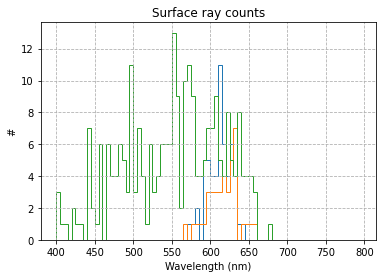

In [23]:
lsc.simulate(250)
lsc.report()

# Get luminescent wavelengths from edge
edge = lsc.spectrum(facets={'left', 'right', 'near', 'far'}, source={'Fluro Red'})

# Get luminescent wavelengths from top and bottom
escape = lsc.spectrum(facets={'top', 'bottom'}, source={'Fluro Red'})

# Get incident wavelengths into top surface
lost = lsc.spectrum(facets={'top'}, source="Oriel Lamp + Filter", kind='first')


plt.hist(edge, bins=np.arange(400, 800, 5), label="edge", histtype='step')
plt.hist(escape, bins=np.arange(400, 800, 5), label="escape",  histtype='step')
plt.hist(lost, bins=np.arange(400, 800, 5), label="lost",  histtype='step')
plt.xlabel('Wavelength (nm)')
plt.ylabel('#')
plt.title("Surface ray counts")
plt.grid(linestyle="dashed")
plt.show()